In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import concatenate
from math import sqrt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [22]:
# Reading finalized datasets
US_data = pd.read_csv(r"C:\Users\akama\OneDrive\Desktop\Data Science Bootcamp\IshMe\Capstone 3 - Time Series Analysis\raw_data\US_data.csv")
CO_emissions = pd.read_csv(r"C:\Users\akama\OneDrive\Desktop\Data Science Bootcamp\IshMe\Capstone 3 - Time Series Analysis\raw_data\CO_emissions.csv")

## Dataset 2 - Preprocessing and Modeling

In [23]:
df2 = CO_emissions.copy()
df2['year'] = pd.to_datetime(df2['year'])
df2.set_index(df2['year'], inplace=True)
df2.drop(columns=['year'], inplace=True)

In [24]:
first_column = df2.pop('co2_per_capita')
df2.insert(0, 'co2_per_capita', first_column)
df2.drop(columns=['share_global_co2', 'flaring_co2_per_capita', 'share_global_coal_co2', 
                  'share_global_cement_co2', 'share_global_gas_co2', 'share_global_oil_co2', 'gdp'], inplace=True)

In [25]:
print(df2.shape)
df2.tail()

(120, 12)


,co2_per_capita,co2,co2_growth_abs,coal_co2,cement_co2,gas_co2,oil_co2,coal_co2_per_capita,cement_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,population
year,,,,,,,,,,,,
2015-01-01,16.868,5412.432,-149.287,1503.253,39.907,1497.933,2278.794,4.685,0.124,4.668,7.102,320878312.0
2016-01-01,16.384,5292.268,-120.165,1378.160,39.439,1509.030,2285.330,4.266,0.122,4.672,7.075,323015992.0
2017-01-01,16.161,5253.606,-38.661,1337.536,40.324,1491.792,2301.967,4.114,0.124,4.589,7.081,325084758.0
2018-01-01,16.585,5424.882,171.275,1282.052,40.324,1653.038,2350.087,3.920,0.123,5.054,7.185,327096263.0
2019-01-01,16.060,5284.697,-140.185,1094.657,41.251,1706.873,2342.536,3.327,0.125,5.187,7.119,329064917.0


In [26]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [27]:
dataset = df2
values = df2.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[13,14,15,16,17,18,19,20,21,22,23]], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var1(t)
1,0.000000,0.000000,0.529909,0.000000,0.000000,0.000000,0.000000,0.420078,0.000000,0.000000,0.000000,0.000000,0.041606
2,0.041606,0.010801,0.552596,0.034651,0.005939,0.000778,0.000958,0.468095,0.019608,0.002753,0.002307,0.006282,0.067372
3,0.067372,0.018749,0.535302,0.056319,0.016694,0.001268,0.003957,0.490968,0.052288,0.004130,0.010426,0.012730,0.167591
4,0.167591,0.042579,0.631557,0.134516,0.025228,0.001759,0.005881,0.610057,0.078431,0.005506,0.015040,0.019347,0.140146
5,0.140146,0.040022,0.471637,0.120799,0.029605,0.002135,0.008572,0.568757,0.091503,0.006293,0.021683,0.026098,0.213285
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.658467,0.895721,0.539995,0.696636,0.836973,0.851670,0.858763,0.191431,0.692810,0.869420,0.620410,0.958484,0.615766
116,0.615766,0.868418,0.321670,0.552378,0.847267,0.876756,0.872859,0.123264,0.692810,0.889282,0.626407,0.967293,0.580438
117,0.580438,0.846441,0.353948,0.473562,0.836973,0.883301,0.875390,0.085232,0.679739,0.890069,0.623916,0.975833,0.564161
118,0.564161,0.839370,0.444286,0.447967,0.856439,0.873133,0.881832,0.071435,0.692810,0.873746,0.624469,0.984099,0.595109


In [28]:
# split into train and test sets
values = reframed.values
n_train_years = 20
train = values[:n_train_years, :]
test = values[n_train_years:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(20, 1, 12) (20,) (99, 1, 12) (99,)


Epoch 1/50
1/1 - 0s - loss: 0.3198 - val_loss: 0.5695
Epoch 2/50
1/1 - 0s - loss: 0.3090 - val_loss: 0.5490
Epoch 3/50
1/1 - 0s - loss: 0.2981 - val_loss: 0.5285
Epoch 4/50
1/1 - 0s - loss: 0.2872 - val_loss: 0.5080
Epoch 5/50
1/1 - 0s - loss: 0.2764 - val_loss: 0.4874
Epoch 6/50
1/1 - 0s - loss: 0.2655 - val_loss: 0.4667
Epoch 7/50
1/1 - 0s - loss: 0.2546 - val_loss: 0.4460
Epoch 8/50
1/1 - 0s - loss: 0.2436 - val_loss: 0.4253
Epoch 9/50
1/1 - 0s - loss: 0.2327 - val_loss: 0.4044
Epoch 10/50
1/1 - 0s - loss: 0.2224 - val_loss: 0.3834
Epoch 11/50
1/1 - 0s - loss: 0.2120 - val_loss: 0.3622
Epoch 12/50
1/1 - 0s - loss: 0.2018 - val_loss: 0.3408
Epoch 13/50
1/1 - 0s - loss: 0.1921 - val_loss: 0.3193
Epoch 14/50
1/1 - 0s - loss: 0.1824 - val_loss: 0.2976
Epoch 15/50
1/1 - 0s - loss: 0.1727 - val_loss: 0.2758
Epoch 16/50
1/1 - 0s - loss: 0.1629 - val_loss: 0.2541
Epoch 17/50
1/1 - 0s - loss: 0.1530 - val_loss: 0.2321
Epoch 18/50
1/1 - 0s - loss: 0.1435 - val_loss: 0.2100
Epoch 19/50
1/1 - 0

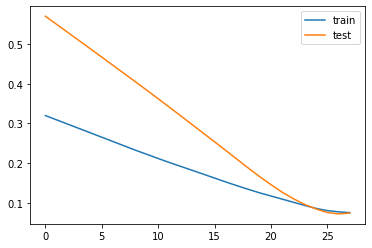

In [29]:
# design network
model = Sequential()
model.add(LSTM(75, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# early stoppings
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='min')
checkpoint =  ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks = [early_stopings,checkpoint]
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, callbacks=callbacks, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.378
